In [96]:
#immporto librerie
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import RMSprop
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [97]:
from sklearn.model_selection import train_test_split

In [98]:
import cv2
import os
import re
import random

In [99]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [100]:
#Unione delle cartelle immagini e caricamento dataset

os.chdir("/content/drive/My Drive/Progetto DL")

folder =  "./dati_genetici.zip"
images = []
labels = [] #etichette 0,1. 0:neutral, 1:selection

#target_size = (48,1000) #Dimensione delle immagini

def load_images_from_folder_recursive(folder):
    """
    Entra ricorsivamente nelle directory che contengono le immagini dei dataset
    di training e di test, le legge e le aggiunge alla lista delle immagini.
    A ogni immagine viene associata un'etichetta: 0 se l'immagine è neutral,
    1 se è una selection.
    """
    for item_name in os.listdir(folder):
        item_path = os.path.join(folder, item_name)

        if os.path.isdir(item_path):
            print(f"Directory: {item_path}")
            load_images_from_folder_recursive(item_path)
        elif os.path.isfile(item_path):
            #print(f"file: {item_path}")
            if re.search(r"selection", item_path):
                labels.append(1)
            else:
                labels.append(0)
            img = cv2.imread(item_path)
            if img is not None:
            #if img.shape != (1000,48,3):
             #   img = cv2.resize(img, target_size)
              images.append(img)


load_images_from_folder_recursive(folder)


print(f"Loaded {len(images)} images.")
print(f"Loaded {len(labels)} labels.")



Directory: ./dati_genetici.zip/NEUTRAL
Directory: ./dati_genetici.zip/NEUTRAL/TEST_IMG
Directory: ./dati_genetici.zip/NEUTRAL/TRAIN_IMG
Directory: ./dati_genetici.zip/SELECTION
Directory: ./dati_genetici.zip/SELECTION/TEST_IMG
Directory: ./dati_genetici.zip/SELECTION/TRAIN_IMG
Loaded 2080 images.
Loaded 2080 labels.


In [101]:
#Eliminazione dell'immagine che ha un formato diverso (1002, 48, 3)
delete_img_index = []
for index,img in enumerate(images):
  if img.shape != (1000,48,3):
    delete_img_index.append(index)

for index in delete_img_index:
  images.pop(index)
  labels.pop(index)

print(f"Loaded {len(images)} images.")
print(f"Loaded {len(labels)} labels.")


Loaded 2079 images.
Loaded 2079 labels.


In [102]:
images[1750].shape

(1000, 48, 3)

In [103]:
#Converto immagine originale con 3 canali colore in 1 canale colore
#Itero su tutte le immagini
grayscale_images = []
for img in images:
    #Nella scala di grigi len(img.shape)==2
    if len(img.shape) > 2 and img.shape[2] == 3:
        #Uso cv2.cvtColor per convertire in scala di grigi
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        grayscale_images.append(gray_img)
    elif len(img.shape) == 2:
        grayscale_images.append(img)
    else:
        print(f"Skipping image with shape: {img.shape}")



In [104]:
# For example, to check the shape of the 1751st image (index 1750)
print(grayscale_images[1750].shape)

(1000, 48)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
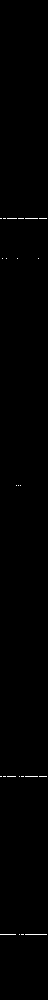

In [105]:
grayscale_images[1568]

In [106]:
random.seed(42)

In [107]:
#Shuffle delle immagini e delle label (allo stesso modo)
shuffled = sorted(zip(grayscale_images, labels), key=lambda _: random.random())
grayscale_images, labels = zip(*shuffled)

X, y = np.array(grayscale_images), np.array(labels)

In [108]:
# Reshape X per aggiungere esplicitamente la dimensione 1 del canale colore
X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)

[[[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 ...

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]]


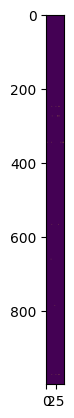

In [109]:
#suddivisione randomica del dataset tra train (70%) e test (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#corversione e normalizzazione
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

print(X_train[444])
plt.imshow(X_train[444]);

In [110]:
#Creazione modello
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D

model_2 = Sequential()

#Primo strato convoluzionale:
# - 16 filtri, ciascuno di dimensione 5x5
# - Stride di 2x2 per ridurre le dimensioni dell'immagine
# - Padding 'same' per mantenere la dimensione spaziale
# - input_shape=(1000,48,1) indica la forma delle immagini
model_2.add(Conv2D(16, (5, 5), strides = (2,2), padding='same', input_shape=(1000,48,1)))
#Funzione di attivazione ReLU per introdurre non-linearità
model_2.add(Activation('relu'))
# Pooling medio per ridurre ulteriormente la dimensione spaziale
model_2.add(MaxPooling2D(pool_size=(2, 2)))
# Dropout al 40% per ridurre l'overfitting
model_2.add(Dropout(0.4))

# Secondo strato convoluzionale:
# - 32 filtri, ciascuno di dimensione 3x3
# - Stride di 1x1
# - padding 'same' per mantenere dimensione compatibile
model_2.add(Conv2D(32, (3, 3), strides=(2, 2), padding='same'))
# Attivazione ReLU
model_2.add(Activation('relu'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))
# Dropout al 40%
model_2.add(Dropout(0.4))

# Appiattimento della mappa dei canali in un vettore per il fully connected layer
model_2.add(Flatten())

# Strato fully connected (denso) con 128 neuroni
model_2.add(Dense(128))
model_2.add(Activation('relu'))
# Dropout al 50% prima dell’output
model_2.add(Dropout(0.5))

# Strato di output con 1 neurone e attivazione sigmoide per classificazione binaria
model_2.add(Dense(1))
model_2.add(Activation('sigmoid'))

# Stampa del riepilogo del modello
model_2.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)              │ (None, 500, 24, 16)    │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_16 (Activation)      │ (None, 500, 24, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 250, 12, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 250, 12, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 125, 6, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_17 (Activation)      │ (None, 125, 6, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 62, 3, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 62, 3, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 5952)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │       761,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_18 (Activation)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │           129 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_19 (Activation)      │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 767,169 (2.93 MB)

 Trainable params: 767,169 (2.93 MB)

 Non-trainable params: 0 (0.00 B)

In [111]:
print(X_train.shape)
print(X_test.shape)

(1455, 1000, 48, 1)
(624, 1000, 48, 1)


In [112]:
#configurazione e addestramento
#Alg: mini-batch gradient descend
from tensorflow.keras.optimizers import  Adam, RMSprop

batch_size = 32


# ottimizzatore RMSprop con learning_rate=0.0005 con weight_decay
opt = RMSprop(learning_rate=0.0005, weight_decay=1e-6)

# Addestramento della rete con loss 'binary_crossentropy', 10 epoche, batch_size 32
model_2.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

run_hist_2=model_2.fit(X_train, y_train,
              batch_size=batch_size,
              epochs=10,
              validation_data=(X_test, y_test),
              shuffle=True)

Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 8s 100ms/step - accuracy: 0.5150 - loss: 0.6817 - val_accuracy: 0.6138 - val_loss: 0.6463
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.6124 - loss: 0.6421 - val_accuracy: 0.6715 - val_loss: 0.6242
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7029 - loss: 0.5980 - val_accuracy: 0.7115 - val_loss: 0.6033
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7694 - loss: 0.5464 - val_accuracy: 0.7404 - val_loss: 0.5855
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7988 - loss: 0.5041 - val_accuracy: 0.7596 - val_loss: 0.5221
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8101 - loss: 0.4308 - val_accuracy: 0.7853 - val_loss: 0.4835
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8308 - loss: 0.3916 - val_accuracy: 0.7821 - val_loss: 0.4648
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8252 - loss: 0.3925 - val_accuracy: 0.7756 - 

In [113]:
#valutazione del modello
results = model_2.evaluate(X_test, y_test, verbose=0)

print(results)

[0.45075544714927673, 0.7948718070983887]


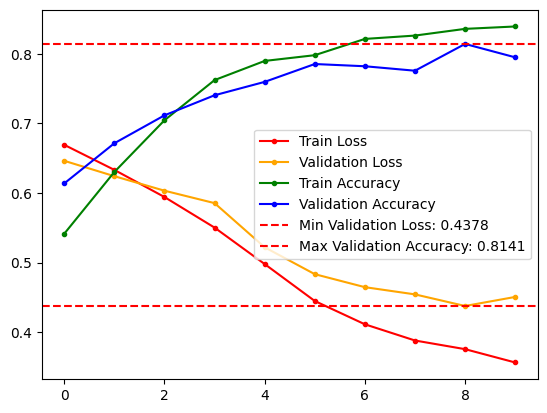

In [114]:
fig, ax = plt.subplots()
ax.plot(run_hist_2.history["loss"],'r', marker='.', label="Train Loss")
ax.plot(run_hist_2.history["val_loss"],'orange', marker='.', label="Validation Loss")
ax.plot(run_hist_2.history["accuracy"],'g', marker='.', label="Train Accuracy")
ax.plot(run_hist_2.history["val_accuracy"],'b', marker='.', label="Validation Accuracy")
plt.axhline(min(run_hist_2.history['val_loss']), color='red', linestyle='--', label=f'Min Validation Loss: {min(run_hist_2.history["val_loss"]):.4f}')
plt.axhline(max(run_hist_2.history['val_accuracy']), color='red', linestyle='--', label=f'Max Validation Accuracy: {max(run_hist_2.history["val_accuracy"]):.4f}')
ax.legend()


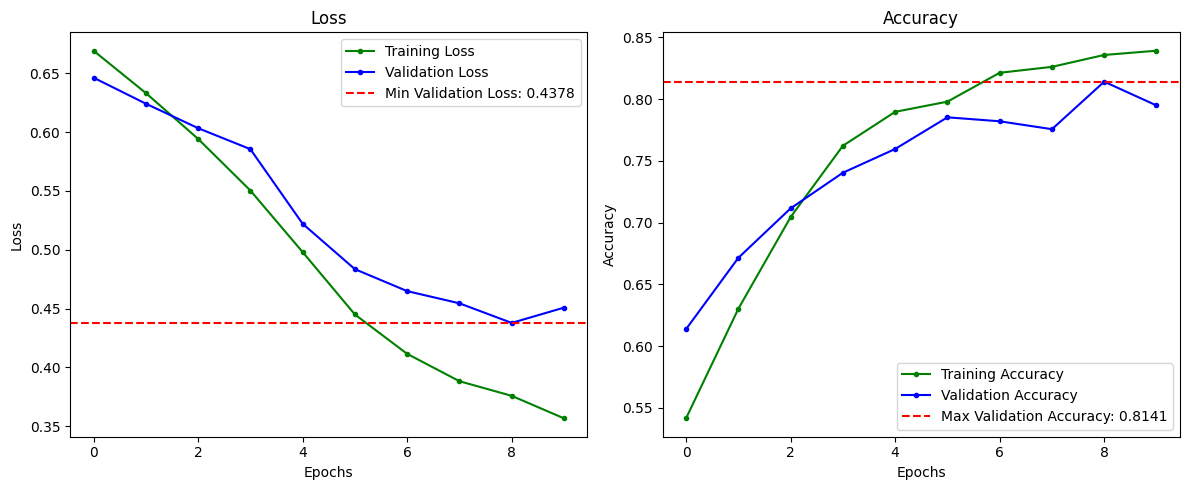

In [115]:
# Plot: andamento training/validation
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(run_hist_2.history['loss'], 'g', marker='.',label='Training Loss')
plt.plot(run_hist_2.history['val_loss'],'b', marker='.', label='Validation Loss')
plt.axhline(min(run_hist_2.history['val_loss']), color='red', linestyle='--', label=f'Min Validation Loss: {min(run_hist_2.history["val_loss"]):.4f}')
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(run_hist_2.history['accuracy'], 'g', marker='.',label='Training Accuracy')
plt.plot(run_hist_2.history['val_accuracy'], 'b', marker='.', label='Validation Accuracy')
plt.axhline(max(run_hist_2.history['val_accuracy']), color='red', linestyle='--', label=f'Max Validation Accuracy: {max(run_hist_2.history["val_accuracy"]):.4f}')
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()